# Packages & housekeeping

In [110]:
import pandas as pd
from pandas import json_normalize 
import datetime
import requests
from datetime import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scipy as sp
import pickle
import os

Changing default plot Font Size

In [111]:
plt.rcParams.update({'font.size': 14})

Description of the API is to be found here:
https://www.vegvesen.no/trafikkdata/api/
and here:
https://www.vegvesen.no/trafikkdata/start/om-api

In [112]:
if not os.path.isdir('figures'):
    os.mkdir('figures')

# Request lists of municipalities and counties

In [113]:
counties_query = \
"""
{
  areas
  {
    counties
    {
      name
      number

    }
  }
}
"""
counties = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': counties_query}).json()['data']['areas']['counties']
counties = json_normalize(counties)
counties.sort_values(by = 'name', inplace = True)
# housekeeping
counties.reset_index(inplace = True)
counties.drop(columns = {'index'},inplace = True)
counties.set_index('number',inplace = True)
counties

,name
number,
42,Agder
34,Innlandet
15,Møre og Romsdal
18,Nordland
3,Oslo
11,Rogaland
54,Troms og Finnmark
50,Trøndelag
38,Vestfold og Telemark


In [114]:
query_municipalities = \
"""{
  areas
  {
    municipalities
    {
      name
      number
      county
      {
        name
      }
    }
  }
}"""
municipalities = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': query_municipalities}).json()['data']['areas']['municipalities']
municipalities = json_normalize(municipalities)
municipalities.rename(columns = {'county.name': 'county'},inplace = True)
municipalities.set_index('county',inplace = True)
municipalities.head()

,name,number
county,,
Trøndelag,Osen,5020
Trøndelag,Oppdal,5021
Trøndelag,Rennebu,5022
Trøndelag,Røros,5025
Trøndelag,Holtålen,5026


In [231]:
municipalities.loc['Rogaland']

,name,number
county,,
Rogaland,Eigersund,1101
Rogaland,Stavanger,1103
Rogaland,Haugesund,1106
Rogaland,Sandnes,1108
Rogaland,Sokndal,1111
Rogaland,Lund,1112
Rogaland,Bjerkreim,1114
Rogaland,Hå,1119
Rogaland,Klepp,1120


# Request traffic registration points (TRP)
The piece of code below requests list of TRP (name, id, coordinates) with the following additional classifiers:
 - traffic registration type: VEHICLE or BICYCLE
 - county (fylke) 
 - municipality (kommune)
 - road: category (E - European route, F - County road, K - Municipal road, P - Private road, R - National road.) and reference

In [116]:
query_TRP = \
"""
{
  trafficRegistrationPoints(searchQuery: {
    roadCategoryIds: []
    countyNumbers: []
    isOperational: true # Filter by traffic registration points currently registering traffic
  }) 
  {
    id
    name
    trafficRegistrationType
    location {
      county
      {
        name
        number
      }
        municipality
      {
        name
        number
      }
      roadReference
      {
        shortForm
        roadCategory
        {
          id
          name
        }
      }
      coordinates {
        latLon {
          lat
          lon
        }
      }
    }
  }
}
"""

TRP = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': query_TRP}).json()['data']['trafficRegistrationPoints']
TRP = json_normalize(TRP)
TRP.drop(columns = ['location.roadReference.roadCategory.name'],inplace = True)
TRP.rename(columns={'location.coordinates.latLon.lat': 'lat',
                    'location.coordinates.latLon.lon': 'lon',
                    'location.roadReference.roadCategory.id':'roadCategory',
                    'location.roadReference.shortForm':'road_ref',
                    'location.county.name':'county',
                    'location.county.number':'county_num',
                    'location.municipality.name':'municipality',
                    'location.municipality.number':'municipality_num',
                    'trafficRegistrationType':'trafficType'
                    }, inplace = True)
TRP = TRP[['id','name','trafficType','municipality','county','roadCategory','road_ref','lat','lon']]
TRP.set_index('id', inplace = True)
TRP.sample(5)

,name,trafficType,municipality,county,roadCategory,road_ref,lat,lon
id,,,,,,,,
95959B971385,JELØGATA SYKKEL,BICYCLE,Moss,Viken,R,RV19 S1D1 m3443,59.433850,10.653880
26581V704695,KIRKENÆR Ø,VEHICLE,Grue,Innlandet,F,FV201 S1D1 m2598,60.451575,12.099986
64673V320066,NÆRBØ,VEHICLE,Hå,Rogaland,F,FV4360 S1D1 m6213,58.665261,5.649371
04525V625637,Ø.Akersvei rampe mot Hvam,VEHICLE,Oslo,Oslo,E,EV6 S17D1 m7291 KD2 m50,59.948419,10.946888
78960V3103562,Ringeriksv ved Løxa mot Sandvika,VEHICLE,Bærum,Viken,E,EV16 S47D70 m4887,59.905782,10.489965


Saving Traffic Registration Points to a csv (can be visualized by by Kepler.gl):

In [118]:
TRP.to_csv('TRP.csv')

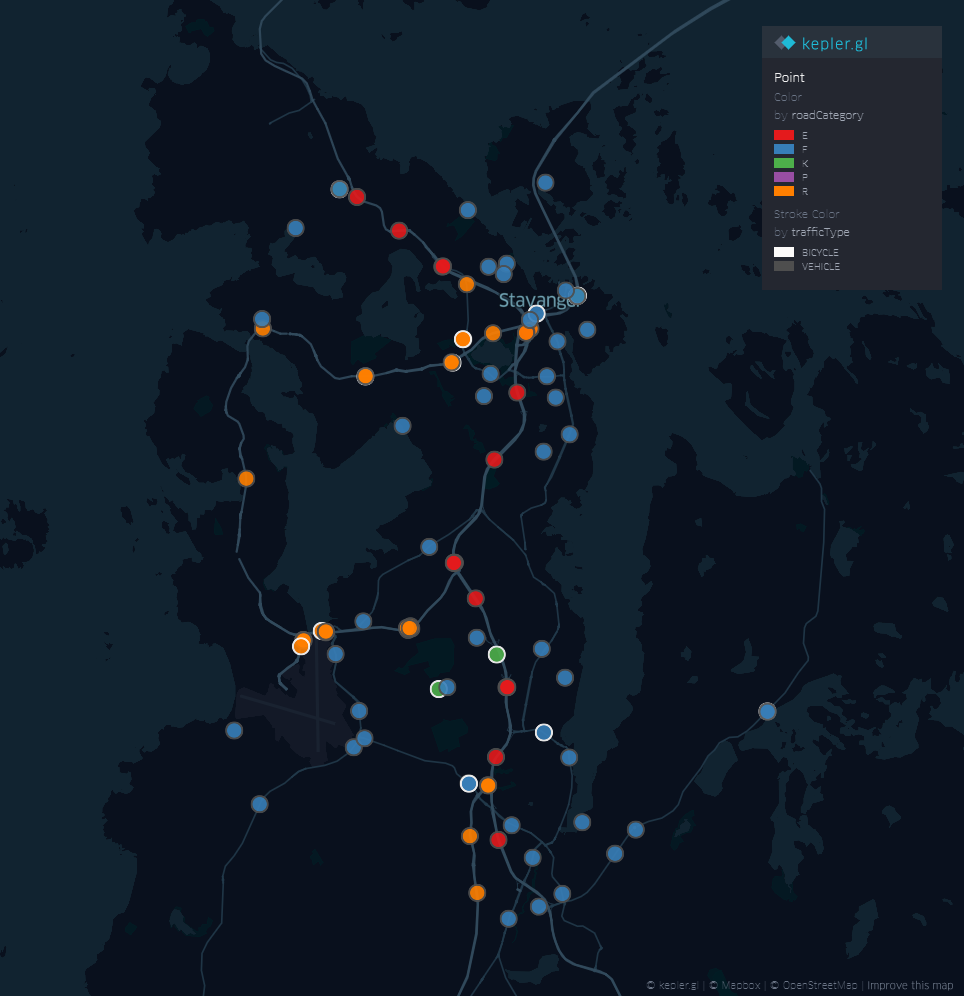

Examples of the different selections:

In [119]:
TRP.loc[(TRP.trafficType == 'VEHICLE') & ((TRP.municipality == 'Sola') | (TRP.municipality == 'Sandnes'))].head()

,name,trafficType,municipality,county,roadCategory,road_ref,lat,lon
id,,,,,,,,
95626V320634,Stangeland nord,VEHICLE,Sola,Rogaland,F,FV510 S2D1 m4656,58.878444,5.655461
63432V319869,SOLA N. ved Arabergv.,VEHICLE,Sola,Rogaland,F,FV510 S2D1 m6281,58.890928,5.645482
64040V320581,E39 / Somaveien,VEHICLE,Sandnes,Rogaland,E,EV39 S101D1 m2650,58.868373,5.713416
13715V2721330,Sømmevågen,VEHICLE,Sola,Rogaland,R,RV509 S1D1 m3891,58.895764,5.641322
73355V319671,AUSTRÅTTUNNELEN,VEHICLE,Sandnes,Rogaland,F,FV516 S1D1 m2472,58.847192,5.763873


In [120]:
TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Sola','Sandnes'])]

,name,trafficType,municipality,county,roadCategory,road_ref,lat,lon
id,,,,,,,,
95626V320634,Stangeland nord,VEHICLE,Sola,Rogaland,F,FV510 S2D1 m4656,58.878444,5.655461
63432V319869,SOLA N. ved Arabergv.,VEHICLE,Sola,Rogaland,F,FV510 S2D1 m6281,58.890928,5.645482
64040V320581,E39 / Somaveien,VEHICLE,Sandnes,Rogaland,E,EV39 S101D1 m2650,58.868373,5.713416
13715V2721330,Sømmevågen,VEHICLE,Sola,Rogaland,R,RV509 S1D1 m3891,58.895764,5.641322
73355V319671,AUSTRÅTTUNNELEN,VEHICLE,Sandnes,Rogaland,F,FV516 S1D1 m2472,58.847192,5.763873
50741V1727509,Smeaheia vest retning Sør,VEHICLE,Sandnes,Rogaland,R,RV444 S1D1 m6639,58.862193,5.709996
41451V320581,FOLKVORD,VEHICLE,Sandnes,Rogaland,E,EV39 S101D1 m4716,58.850215,5.714475
89457V2303027,Eikeberget NØ rampe,VEHICLE,Sola,Rogaland,R,RV509 S1D1 m1799 KD1 m309,58.897005,5.677165
33926V2721315,Flyplassvegen Sola,VEHICLE,Sola,Rogaland,R,RV509 S1D10 m267,58.893961,5.631846


# Getting prepared to read traffic data

Public holidays in Norway
https://www.timeanddate.no/merkedag/norge/2019?hol=1

In [121]:
id = '68351V319882' # Kannik
id = '66678V320582' # AUGLEND
id = '26738V320582' # E39 Forus nord
id = '71798V319583' # Forus ved Stv.Aftenblad påkj. mot Sandnes
id = '84064V320581' # FORUS ved Stv.Aftenblad

Today's time and date:

In [122]:
time_now_str = str(datetime.utcnow().date()) + 'T00:00:00+02:00'
time_now_str

'2020-07-29T00:00:00+02:00'

## Query templates

### Template for Average daily traffic volume per year
#id - id of a TRP
Note: "Coverage is a measure for how much of a time period there is valid data for. For traffic volume per hour or day, coverage is the ratio of time with valid data to the whole time period. For average daily traffic volume, coverage is the average coverage for days with sufficient coverage (>95%), multiplied by the ratio of number of days with sufficient coverage (>95%) to the total number of days in the period."

In [123]:
query_YADTV_temp = """
{
  trafficData(trafficRegistrationPointId: "#id") {
    volume {
      average {
        daily {
          byYear {
            year
            total {
              volume {
                average
                confidenceInterval {
                  lowerBound
                  upperBound
                }
              }
              coverage {
                percentage
              }
            }
          }
        }
      }
    }
  }
}
"""

### Template for hourly traffic volume

In [124]:
query_HTV_temp = """{
  trafficData(trafficRegistrationPointId: "#id") {
    volume {
      byHour(from: "#t1", to: "#t2") {
        edges {
          node {
            from
            to
            total {
              volumeNumbers {
                volume
              }
              coverage {
                percentage
              }
            }
          }
        }
      }
    }
  }
}"""

### Template for daily traffic volume

In [125]:
query_DTV_temp = """{
  trafficData(trafficRegistrationPointId: "#id") {
    volume {
      byDay(from: "#t1", to: "#t2") {
        edges {
          node {
            from
            to
            total {
              volumeNumbers {
                volume
              }
              coverage {
                percentage
              }
            }
          }
        }
      }
    }
  }
}"""

Example for id ='40190V319527' #SOKN - TRP on E39, to the north of Stavanger

In [126]:
import requests
import pandas as pd
from pandas import json_normalize 

query_example = """{
  trafficData(trafficRegistrationPointId: "40190V319527") {
    volume {
      byDay(from: "2019-01-01T00:00:00+02:00", to: "2020-07-23T00:00:00+02:00") {
        edges {
          node {
            from
            to
            total {
              volumeNumbers {
                volume
              }
              coverage {
                percentage
              }}}}}}}}"""

DTV = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': query_example}).json()
DTV = DTV['data']['trafficData']['volume']['byDay']['edges']
DTV = json_normalize(DTV)
DTV.head()

,node.from,node.to,node.total.volumeNumbers.volume,node.total.coverage.percentage
0,2019-01-01T00:00:00+01:00,2019-01-02T00:00:00+01:00,5720,100.0
1,2019-01-02T00:00:00+01:00,2019-01-03T00:00:00+01:00,9124,100.0
2,2019-01-03T00:00:00+01:00,2019-01-04T00:00:00+01:00,8574,100.0
3,2019-01-04T00:00:00+01:00,2019-01-05T00:00:00+01:00,9197,100.0
4,2019-01-05T00:00:00+01:00,2019-01-06T00:00:00+01:00,6359,100.0


## Functions to request and process traffic data

Function to build a query from a template (QT) for the specified TRP id (id) and time interval (t1 and t2):

In [127]:
def create_query(QT, 
                 id = '44656V72812', 
                 t1 = '2019-01-01T00:00:00+02:00', 
                 t2 = time_now_str):
    Q = QT.replace('#id',id)
    Q = Q.replace('#t1',t1)
    Q = Q.replace('#t2',t2)
    return Q

### Request function
1. requests Yearly Averaged Daily Traffic Volume (YADTV) for 2019
2. requests daily traffic data for one TRP
3. calculates the traffic index as: [2]/[1]
4. calculates 7-day moving average

In [128]:
def request_traffic_data(id = '44656V72812', disp = False, t1 = '2018-12-01T00:00:00+02:00',t2 = time_now_str):
    # reading yearly averaged daily traffic volume for TRP with id, from t1 to t2
    # disp
    query_YADTV = create_query(query_YADTV_temp,id)
    DTV = pd.DataFrame()
    YADTV = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': query_YADTV}).json()
    if disp:
        print(YADTV)
#     try:
    YADTV = YADTV['data']['trafficData']['volume']['average']['daily']['byYear']
    YADTV = json_normalize(YADTV)
    YADTV.rename(columns={'total.coverage.percentage': 'coverage','total.volume.average':'volume',
                      'total.volume.confidenceInterval.lowerBound': 'volume_LB',
                      'total.volume.confidenceInterval.upperBound': 'volume_UB'}, inplace = True)
    YADTV = YADTV[YADTV.columns[::-1]]
    YADTV.set_index('year', inplace = True)
    # reading daily traffic volume
    t1_num = datetime.fromisoformat(t1).toordinal()
    t2_num = datetime.fromisoformat(t2).toordinal()
    while t1_num < t2_num:
        query_DTV = create_query(query_DTV_temp, id, t1, t2)
        #print(' from ' + t1 + ' to ' + t2)
        DTV_temp = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': query_DTV}).json()
        DTV_temp = DTV_temp['data']['trafficData']['volume']['byDay']['edges']
        DTV_temp = json_normalize(DTV_temp)

        if DTV_temp.empty:
            break

#         DTV_temp['date0'] = DTV_temp['node.to']
        DTV_temp['date'] = pd.to_datetime(DTV_temp['node.to'],utc=True).dt.date
        t1 = DTV_temp['node.to'].iloc[-1]       
        t1_num = datetime.fromisoformat(t1).toordinal()  
        DTV_temp.drop(columns = {'node.to','node.from'},inplace=True)
        try:
            DTV_temp.rename(columns={'node.total.volumeNumbers.volume': 'volume',
                                    'node.total.coverage.percentage':'coverage'},inplace = True)                  
#             print(DTV_temp.head(1))   
            
            if 'volume' not in  DTV_temp.columns:
                DTV_temp['volume'] = None

            DTV_temp = DTV_temp[['date','volume','coverage',]]
            DTV = pd.concat([DTV, DTV_temp],sort=False)
            if disp:
                print('--------------------------------------')    
                print(DTV_temp.iloc[[0, -1]])
#                 print(DTV_temp.tail(1))             
        except:
            if disp:
                print('-------error--------------------------')  
            continue  
    
    DTV['traffic_index'] = DTV['volume']/YADTV['volume'][2019]
    # Adding a column with 7-day moving average
    DTV['traffic_index_MA7'] = DTV['traffic_index'].rolling(window = 7).mean()
    DTV['YADTV'] = YADTV['volume'][2019]
    DTV.set_index('date', inplace = True)          
    return DTV

### Looped requests
    - request the data for many TRPs in loop
    - save the results as a dictionary of Pandas dataframes TDD (TDD - traffic data dictionary) :

In [129]:
def request_traffic_data_loop(IDs, case_name = None):
    if not os.path.exists('TDD_' + case_name + '.pkl'):
        t1 = datetime.now()
        L = len(IDs)
        if case_name == None:
            case_name =  str(L) + '_IDs'
        
        save2 = 'TDD_' + case_name + '.pkl'
        log_file = save2.replace('.pkl','.log')
        
        lf = open(log_file,'w')
        print(len(IDs),' TRP(s) to read')
        
        c = 0
        TDD = dict()
        for i,id in enumerate(IDs):
            log_str = str(i)+'. '+ id +', '+ str(TRP.loc[id,'roadCategory'])+', ' + \
            TRP.loc[id,'county']+', '+TRP.loc[id,'municipality']+', '+TRP.loc[id,'name']
            try:
                TDD[id] =  request_traffic_data(id)
                log_str = log_str + ' - ok'
                c = c + 1
            except:
                log_str = log_str + ' - some error!'
                continue
                
            print(log_str)
            
            lf.write(log_str + '\n')  
#         with open(log_file,'a') as lf:
#             lf.write(log_str + '\n')    

            if (i + 1) % 25 == 0:
                clear_output()
        # saving
        lf.close()
        t2 = datetime.now()
        print(c,'( out of ',L,') TRPs successfully polled')
        print('Elapsed time:',(t2 - t1).total_seconds(),' s')

        outfile = open(save2,'wb')
        pickle.dump(TDD,outfile)
        outfile.close()

        print('TDD is saved in ' + save2)
    else:
        # loading from the file
        print('reading TDD_' + case_name + '.pkl' )
        ff = open('TDD_' + case_name + '.pkl','rb')
        TDD = pickle.load(ff)
        ff.close()
    return TDD

### plot Traffic Index (TI)

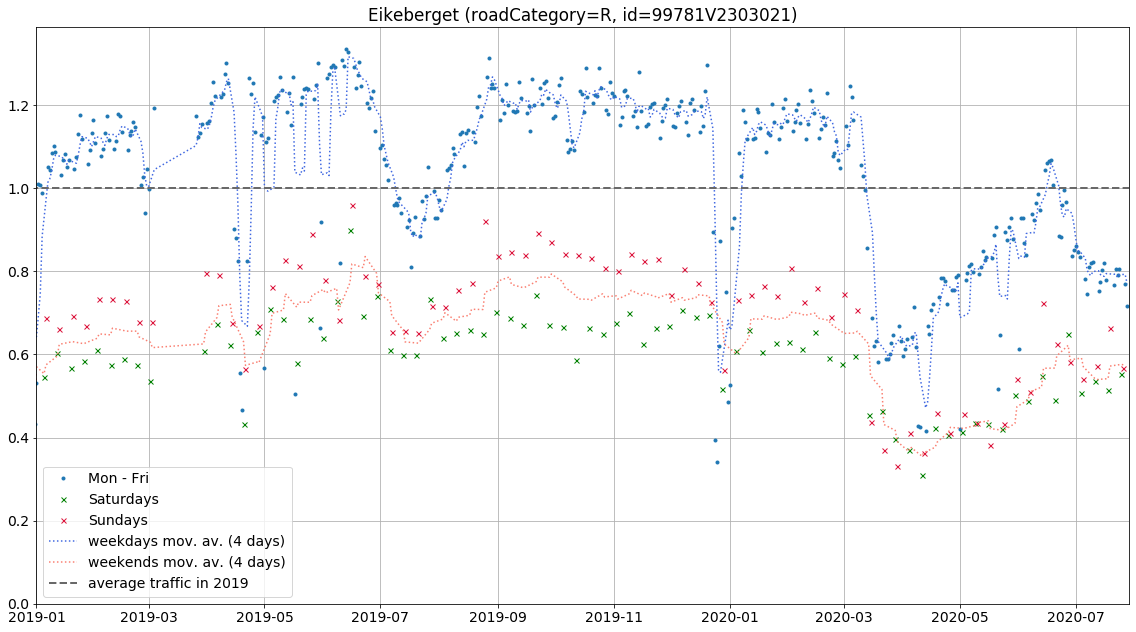

In [215]:
def plot_TI(DTV,id = None, **kwargs):
    # defaults
    
    # to save or not to save: boolean
    save_switch = kwargs.get('save')       
    
    # from date (yyyy.mm.dd)
    from_date = kwargs.get('from_date')
    if from_date == None:
        from_date = '2019-01-01'
    
    fridays = kwargs.get('fridays')
    if fridays == None:
        fridays == False
        
    
    # to date (yyyy.mm.dd)
    to_date   = kwargs.get('to_date')
    if to_date == None:
        to_date = time_now_str

    # title
    ttl   = kwargs.get('title')
    
    # moving averages (like: MA = 5, where 5 is the window size)
    MA   = kwargs.get('MA')

    ylim  = kwargs.get('ylim')

    plt.figure(figsize=(16,9)) # PPT presentation
    
    
    if type(DTV) == pd.core.series.Series:        
        y = DTV
    else:
        DTV.dropna(subset = ['traffic_index'], inplace = True)
        DTV = DTV.loc[DTV['coverage'] > 95,:] # dropping points with coverage less than 95%
        y = DTV['traffic_index']
    
    x = DTV.index
    
    mon_fri = pd.to_datetime(DTV.index).dayofweek.isin(range(5))
    sat = pd.to_datetime(DTV.index).dayofweek.isin([5])
    sun = pd.to_datetime(DTV.index).dayofweek.isin([6])
    sat_sun = pd.to_datetime(DTV.index).dayofweek.isin([5,6])
        
    if fridays == True:
        mon_thu = pd.to_datetime(DTV.index).dayofweek.isin(range(4))
        fri = pd.to_datetime(DTV.index).dayofweek.isin([4])
        plt.plot_date(x[mon_thu],y[mon_thu], markersize = 3,label = 'Mon - Thu')  
        plt.plot_date(x[fri],   y[fri], markersize = 5, color = '#1f77b4', label = 'Fridays')
        plt.plot_date(x[sat],   y[sat],'x', markersize = 5, color = 'green',label = 'Saturdays')
        plt.plot_date(x[sun],    y[sun], 'x', markersize = 5, color = 'crimson',label = 'Sundays')      
    else:
        plt.plot_date(x[mon_fri],y[mon_fri], markersize = 3,label = 'Mon - Fri')    
        plt.plot_date(x[sat],   y[sat],'x', markersize = 5, color = 'green',label = 'Saturdays')
        plt.plot_date(x[sun],    y[sun], 'x', markersize = 5, color = 'crimson',label = 'Sundays')    
        
        
    if MA != None:
        plt.plot_date(x[mon_fri],y[mon_fri].rolling(window = MA).mean(), ':', color = 'royalblue',label = 'weekdays mov. av. ('+  str(MA)+ ' days)') 
        plt.plot_date(x[sat_sun],y[sat_sun].rolling(window = MA).mean(), ':', color = 'salmon',   label = 'weekends mov. av. (' + str(MA)+ ' days)') 

    plt.plot_date(list(plt.xlim()),[1,1],'--',color = 'dimgrey',label = 'average traffic in 2019',linewidth = 2)
    
    from_date = datetime.fromisoformat(from_date).date()
    to_date = datetime.fromisoformat(to_date).date()
    
    plt.xlim(from_date,to_date)
    if ylim != None:
        plt.ylim(ylim)
    else:
        plt.ylim(ymin = 0)
        
    ylim = plt.ylim()
    
    if ttl == None:
        if id != None:
            ttl = TRP['name'][id] + ' (roadCategory=' + TRP['roadCategory'][id] + ', id='  + id + ')'
            plt.title(ttl) 
    else:     
        plt.title(ttl); # , fontsize = 16

    marks = kwargs.get('marks')
    if marks != None:
        for k in marks.keys():
            d = k.replace('-','.')
            d = datetime.strptime(d,'%Y.%m.%d')
            if marks[k].get('ls') == None:
                marks[k]['ls'] = sp.random.choice(['--','-.',':'])
            if marks[k].get('c') == None:
                marks[k]['c'] = sp.random.choice(['dimgrey','maroon','navy','forestgreen'])
            plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)
        
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
    if save_switch == True:
        plt.savefig('.\\figures\\' + ttl + '.png',dpi=300)

    plt.show()
        
id = '99781V2303021' #'Eikeberget'
DTV = request_traffic_data(id)
plot_TI(DTV, id, from_date = '2019-01-01', to_date = time_now_str, MA = 4, save = True)    

### TDD processing
- converts TDD into single DataFrame
- drops NaN and points with coverage less than 90%

In [131]:
# def process_TDD(X, **kwargs):
def process_TDD(X, IDs = None):
    
    # checking if IDs is iterable
    try:
        for i in IDs:
            pass
    except:
        IDs = X.keys()

#     print(IDs)
    Y = pd.DataFrame()
    
    for i in IDs:
        try:
            X[i]['id'] = i
            Y = pd.concat([Y,X[i]])
        except:
            continue
        
#     Y['id'].astype('category', inplace = True)
    Y = Y.loc[Y['coverage'] > 90,:]
    Y.dropna(subset = ['traffic_index'],inplace = True) 
    return Y

# # GSV = process_TDD(GSV, IDs)
# TRP_Randaberg = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Randaberg'])]
# # TRP_Randaberg
# R = request_traffic_data_loop(TRP_Randaberg.index,'Randaberg')   
# RR = process_TDD(R,TRP_Randaberg.index)
# RR.head()

### Weighted average function

In [132]:
def wavg(df, avg_col_name, weight_col_name):
    x = df[avg_col_name]
    w = df[weight_col_name]
    try:
        return (x * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

## Some demos

### Requesting and plotting traffic data 

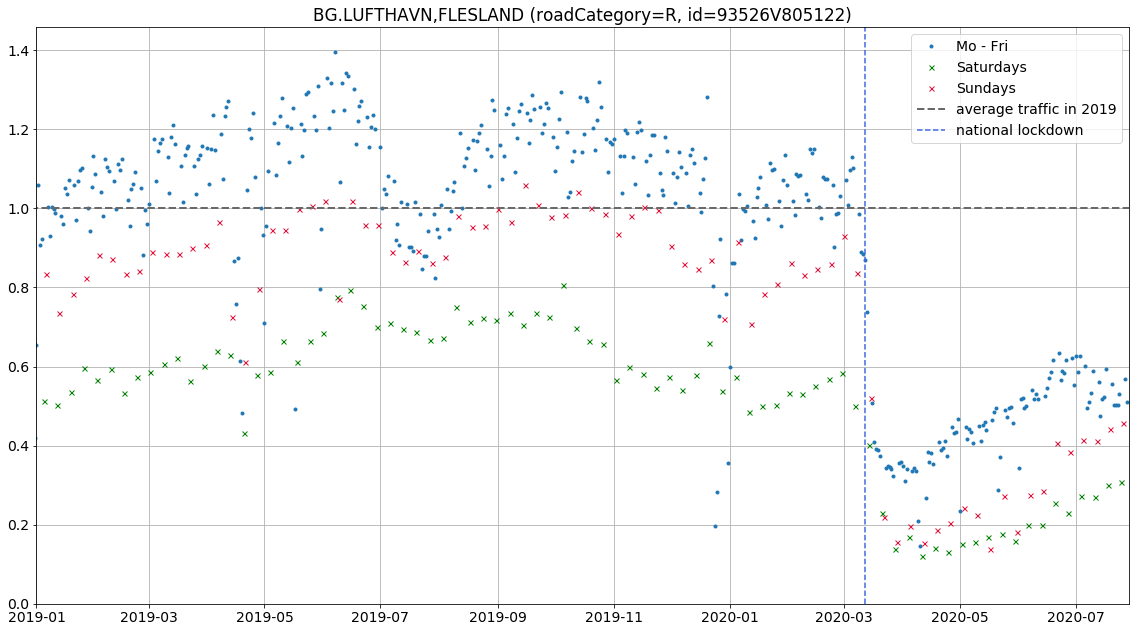

In [133]:
# id = '68351V319882' # Kannik
# id = '66678V320582' # AUGLEND
# id = '99781V2303021' #'Eikeberget'
# id='68684V319527' # Askje
# id ='40190V319527' #SOKN - TRP on E39, to the north of Stavanger
# id = '35382V1727514' # Smeaheia Vest retning Nord
# id = '13715V2721330' # name Sømmevågen - enterance to the Sola airport
# id = '26738V320582' # E39 Forus nord
id = '93526V805122' # BG.LUFTHAVN,FLESLAND
# id = '61487V319872' # Risavika

# M = {'national lockdown': {'date': '2020.03.12','color': 'red','linestyle': '--'}, 'HB':{'date': '2020.03.30'}}
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}, 
#      '2020.04.27':{'label':'schools reopen'},
#      '2019.06.20':{'label':'Sommerruter','ls': '--','c': 'grey'},
#      '2019.08.16':{'label':'Sommerruter','ls': '--','c': 'grey'},
    }

DTV = request_traffic_data(id)
plot_TI(DTV, id, from_date = '2019-01-01', to_date = time_now_str, marks = M)

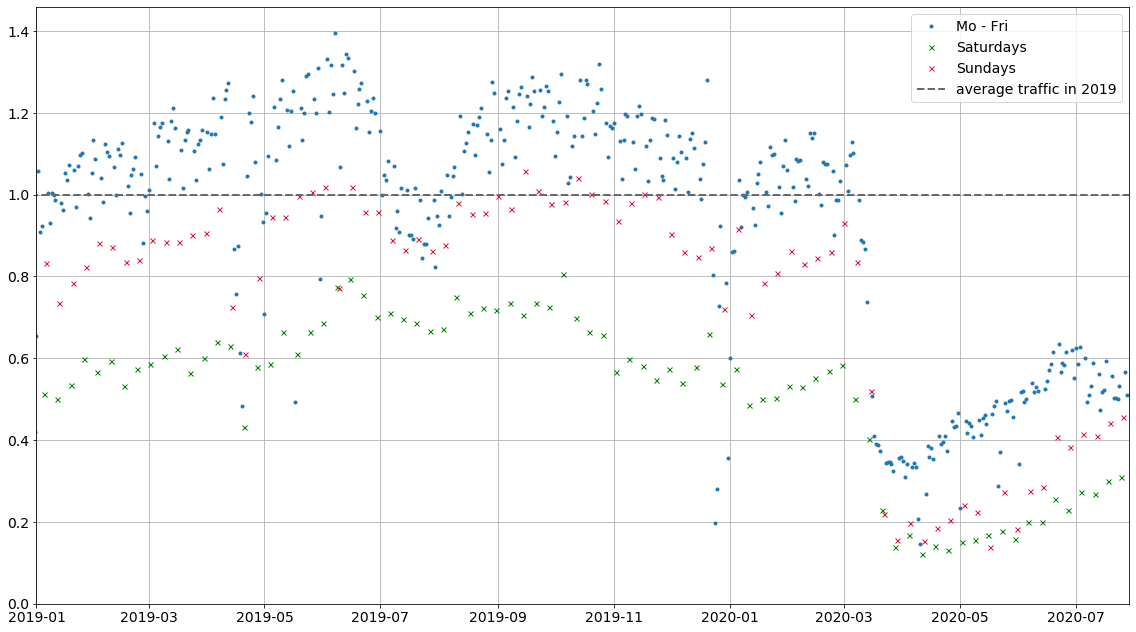

In [134]:
plot_TI(DTV)

In [135]:
DTV.head()

,volume,coverage,traffic_index,traffic_index_MA7,YADTV
date,,,,,
2018-12-01,8250,100.0,0.587481,NaN,14043
2018-12-02,12757,100.0,0.908424,NaN,14043
2018-12-03,15025,100.0,1.069928,NaN,14043
2018-12-04,14042,100.0,0.999929,NaN,14043
2018-12-05,15112,100.0,1.076123,NaN,14043


In [136]:
DTV.tail()

,volume,coverage,traffic_index,traffic_index_MA7,YADTV
date,,,,,
2020-07-24,7466,100.0,0.531653,0.477187,14043
2020-07-25,4337,100.0,0.308837,0.478357,14043
2020-07-26,6426,100.0,0.457595,0.480443,14043
2020-07-27,7966,100.0,0.567258,0.481999,14043
2020-07-28,7182,100.0,0.511429,0.483067,14043


### Randaberg

Requesting vehicle data from all TRPs in Randaberg:

In [137]:
TRP_Randaberg = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Randaberg'])]
TRP_Randaberg

,name,trafficType,municipality,county,roadCategory,road_ref,lat,lon
id,,,,,,,,
52780V320689,Håland,VEHICLE,Randaberg,Rogaland,F,FV4560 S2D1 m1390,58.984062,5.628547
05658V320707,Randabergsletta,VEHICLE,Randaberg,Rogaland,F,FV4590 S3D1 m123,58.992550,5.647208


Requesting traffic data for the selected TRP and saving them:

In [138]:
R = request_traffic_data_loop(TRP_Randaberg.index,'Randaberg') 
R['52780V320689'].iloc[[0,1,-2,-1],:]

reading TDD_Randaberg.pkl


,volume,coverage,traffic_index,traffic_index_MA7,YADTV
date,,,,,
2018-12-01,4551,100.0,0.650236,NaN,6999
2018-12-02,4321,100.0,0.617374,NaN,6999
2020-07-27,6991,100.0,0.998857,0.898149,6999
2020-07-28,6720,100.0,0.960137,0.896700,6999


Merging data into single DataFrame:

In [139]:
RR = process_TDD(R)
RR.sample(5)

,volume,coverage,traffic_index,traffic_index_MA7,YADTV,id
date,,,,,,
2019-02-07,9882,100.0,1.158907,1.007723,8527,05658V320707
2020-04-07,6595,100.0,0.942277,0.739310,6999,52780V320689
2019-03-21,10269,100.0,1.204292,1.044548,8527,05658V320707
2020-06-28,5773,100.0,0.824832,1.215786,6999,52780V320689
2020-03-23,7075,100.0,0.829717,0.757074,8527,05658V320707


# Polling all TRPs in Norway
NB!
Execution of the code block below takes ca. one hour!

After successful run, a file with name ('TDD_' + case_name + '.pkl') is created and will be uploaded during subsequent runs. 

Remove this file if you need to request data anew.

In [140]:
case_name = 'ALL' 
# os.remove('TDD_' + case_name + '.pkl') # uncomment this line to request the data anew
IDs = TRP.index
ALL = request_traffic_data_loop(IDs, case_name) 

reading TDD_ALL.pkl


# Analysis

## Oslo

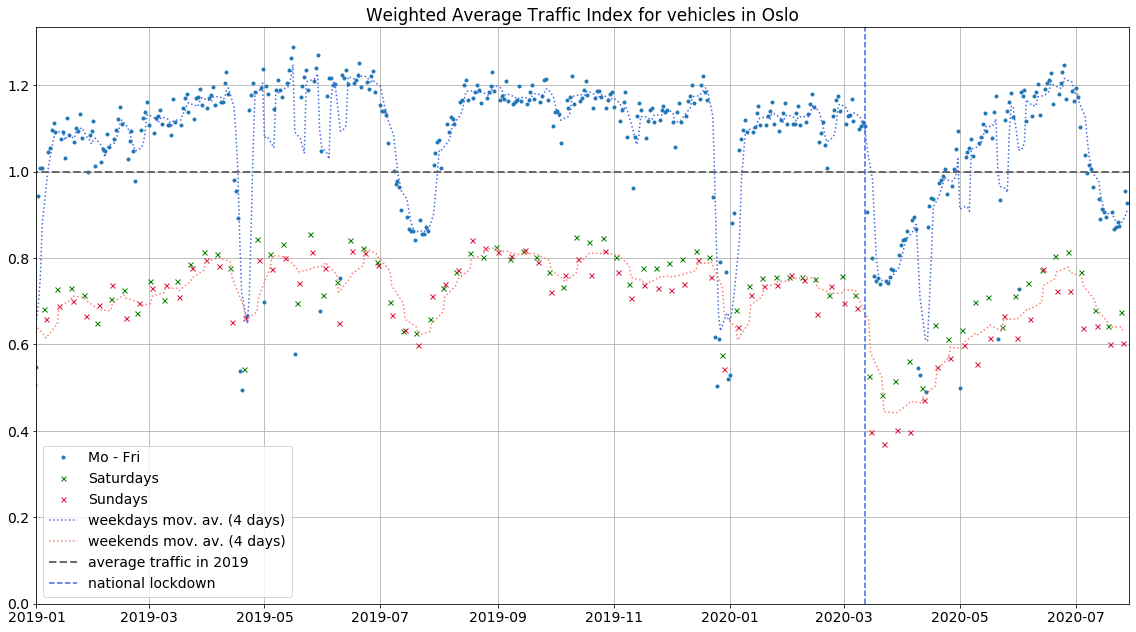

In [141]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Oslo'])].index
OSL = process_TDD(ALL,IDs)
OSL_wavg = OSL.groupby('date').apply(wavg,'traffic_index','YADTV')
OSL_d = OSL['traffic_index'].groupby('date').describe()

M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}, 
#      '2020.04.27':{'label':'schools reopen'},
    }
plot_TI(OSL_wavg,marks = M, title = 'Weighted Average Traffic Index for vehicles in Oslo', save = True, MA = 4)

In [142]:
ALL['52780V320689']

,volume,coverage,traffic_index,traffic_index_MA7,YADTV
date,,,,,
2018-12-01,4551,100.0,0.650236,NaN,6999
2018-12-02,4321,100.0,0.617374,NaN,6999
2018-12-03,7857,100.0,1.122589,NaN,6999
2018-12-04,7905,100.0,1.129447,NaN,6999
2018-12-05,8198,100.0,1.171310,NaN,6999
...,...,...,...,...,...
2020-07-24,6716,100.0,0.959566,0.899659,6999
2020-07-25,4779,100.0,0.682812,0.902721,6999
2020-07-26,4977,100.0,0.711102,0.900639,6999


## Bergen

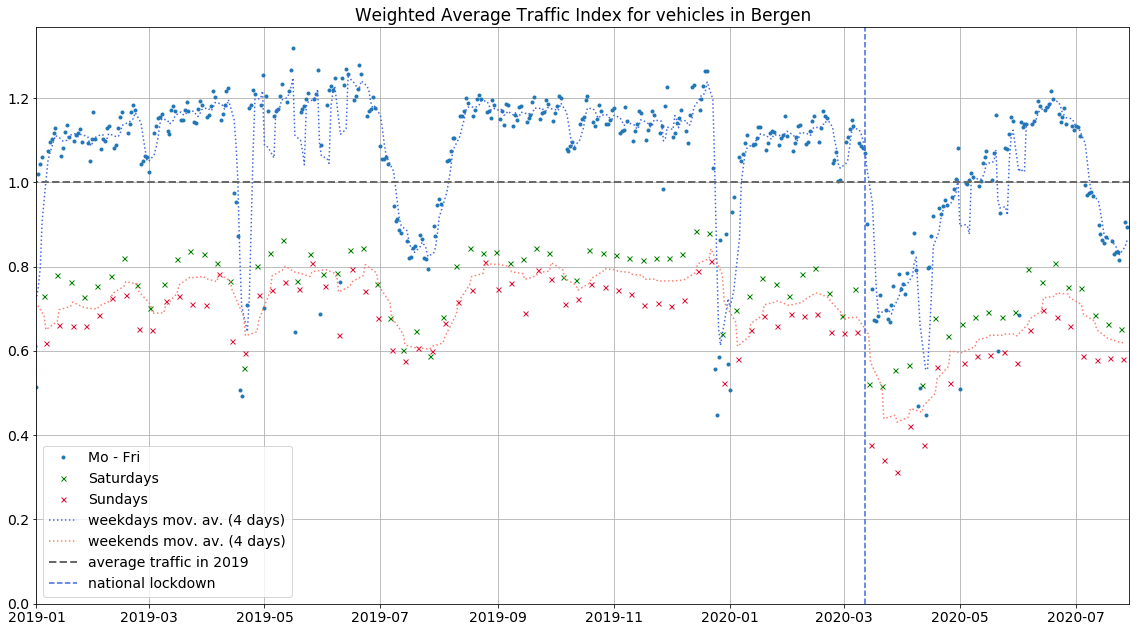

In [143]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Bergen'])].index
BRG = process_TDD(ALL,IDs)
BRG_wavg = BRG.groupby('date').apply(wavg,'traffic_index','YADTV')
BRG_d = BRG['traffic_index'].groupby('date').describe()

M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}, 
#      '2020.04.27':{'label':'schools reopen'},
    }
plot_TI(BRG_wavg,marks = M, title = 'Weighted Average Traffic Index for vehicles in Bergen', save = True, MA = 4)

## The Greater Stavanger Area

Stavanger, Sola, Sandness and Randaberg

### Vehicles

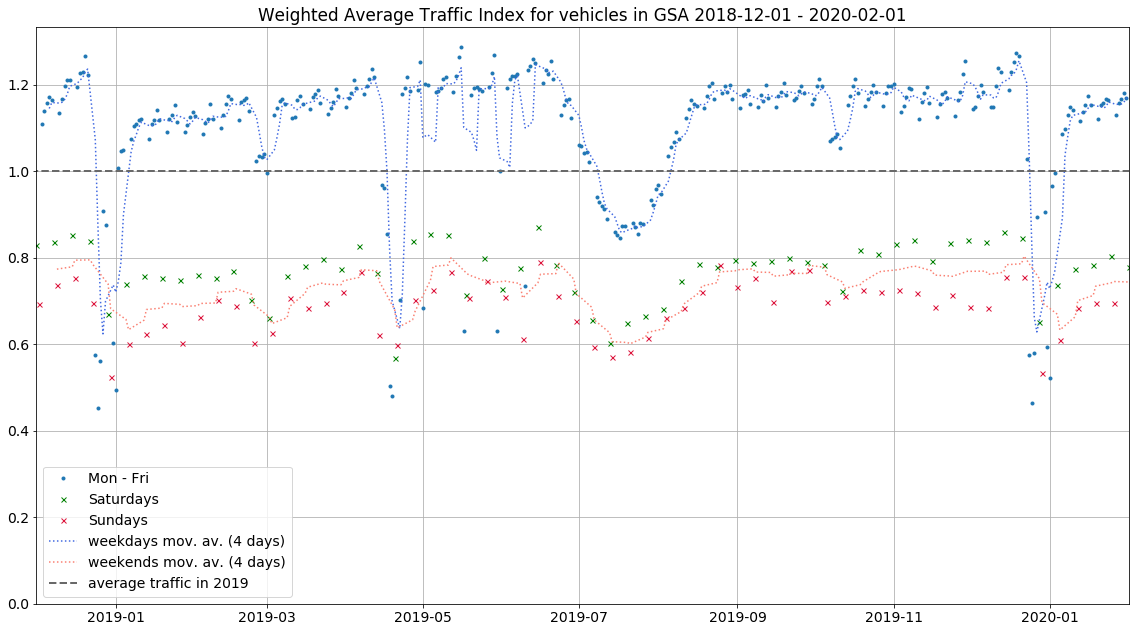

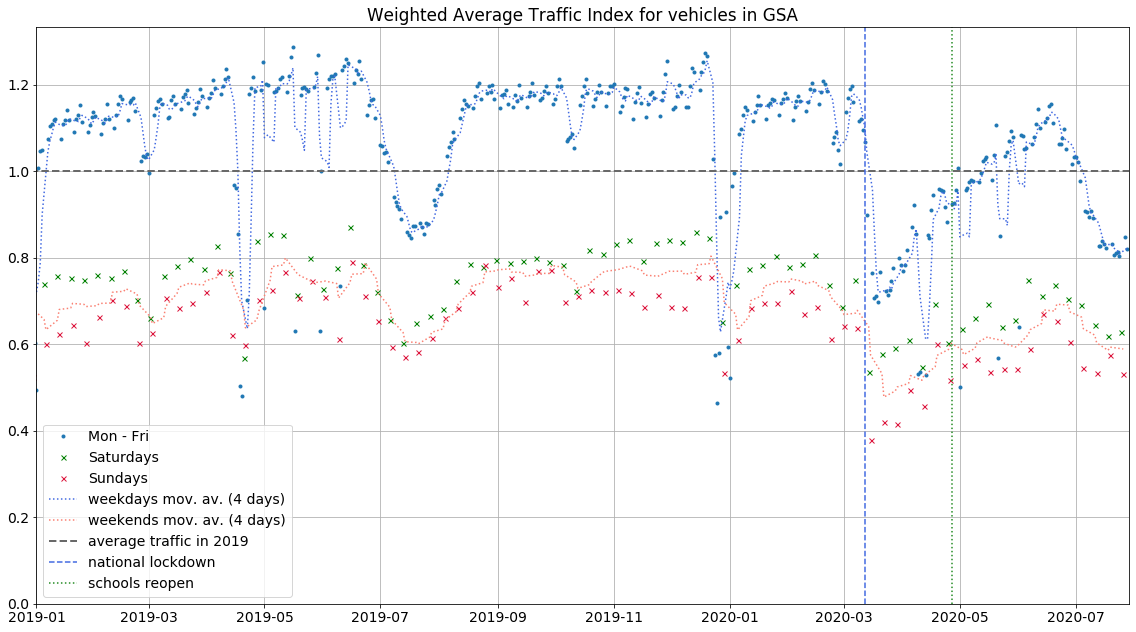

In [227]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Stavanger','Sola','Sandnes','Randaberg'])].index
GSV = process_TDD(ALL,IDs)

GSV_wavg = GSV.groupby('date').apply(wavg,'traffic_index','YADTV')
GSV_d = GSV['traffic_index'].groupby('date').describe()
GSV_d.head()


M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}, 
     '2020.04.27':{'label':'schools reopen'},
#      '2019.06.20':{'label':'Sommerruter','ls': '--','c': 'grey'},
#      '2019.08.16':{'ls': '--','c': 'grey'},
    }

plot_TI(GSV_wavg,marks = {}, title = 'Weighted Average Traffic Index for vehicles in GSA 2018-12-01 - 2020-02-01', from_date = '2018-12-01', to_date = '2020-02-01', save = True, MA = 4)
plot_TI(GSV_wavg,marks = M, title = 'Weighted Average Traffic Index for vehicles in GSA', save = True, MA = 4)

### Bicycles

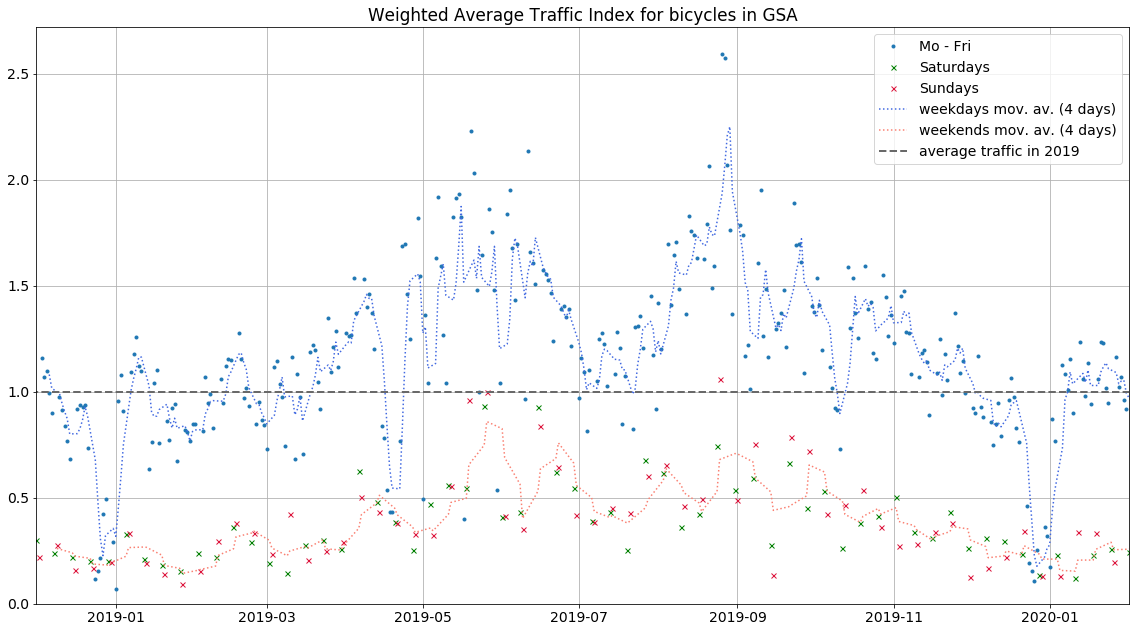

In [145]:
IDs = TRP.loc[(TRP.trafficType == 'BICYCLE') & TRP.municipality.isin(['Stavanger','Sola','Sandnes','Randaberg'])].index
GSB = process_TDD(ALL, IDs)

GSB_wavg = GSB.groupby('date').apply(wavg,'traffic_index','YADTV')
GSB_d = GSB['traffic_index'].groupby('date').describe()

plot_TI(GSB_wavg, title = 'Weighted Average Traffic Index for bicycles in GSA', from_date = '2018-12-01', to_date = '2020-02-01',  save = True, MA = 4)

## Comparison of Oslo, Bergen and Stavanger

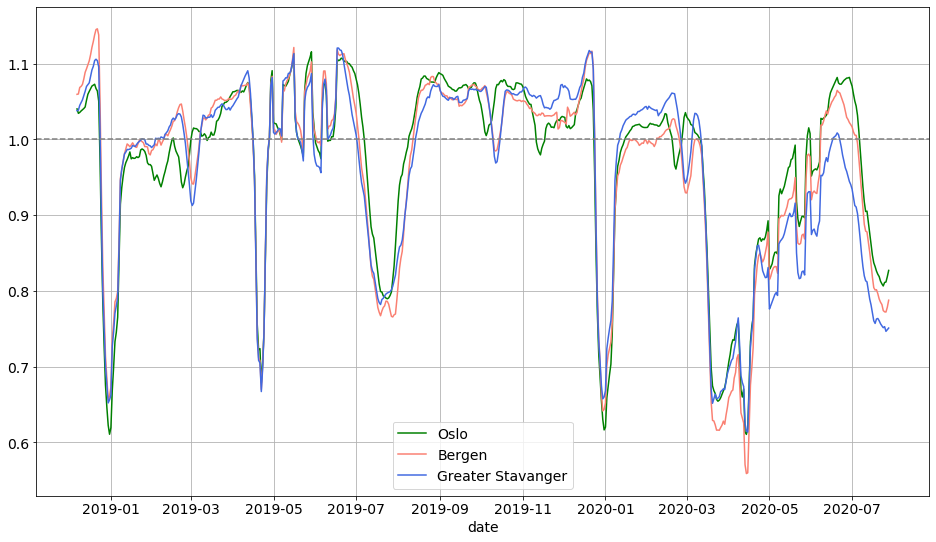

In [166]:
OSL_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Oslo', color = 'green', legend = True)
BRG_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Bergen', color = 'salmon', legend = True)
GSV_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Greater Stavanger', color = 'royalblue', legend = True)
xl = plt.xlim()
plt.plot(xl, [1, 1],'--', color = 'gray')
plt.xlim(xl)
plt.savefig('.\\figures\\Comparison of Oslo, Bergen and Stavanger.png',dpi=300)
plt.show()

## Norway

### Vehicles

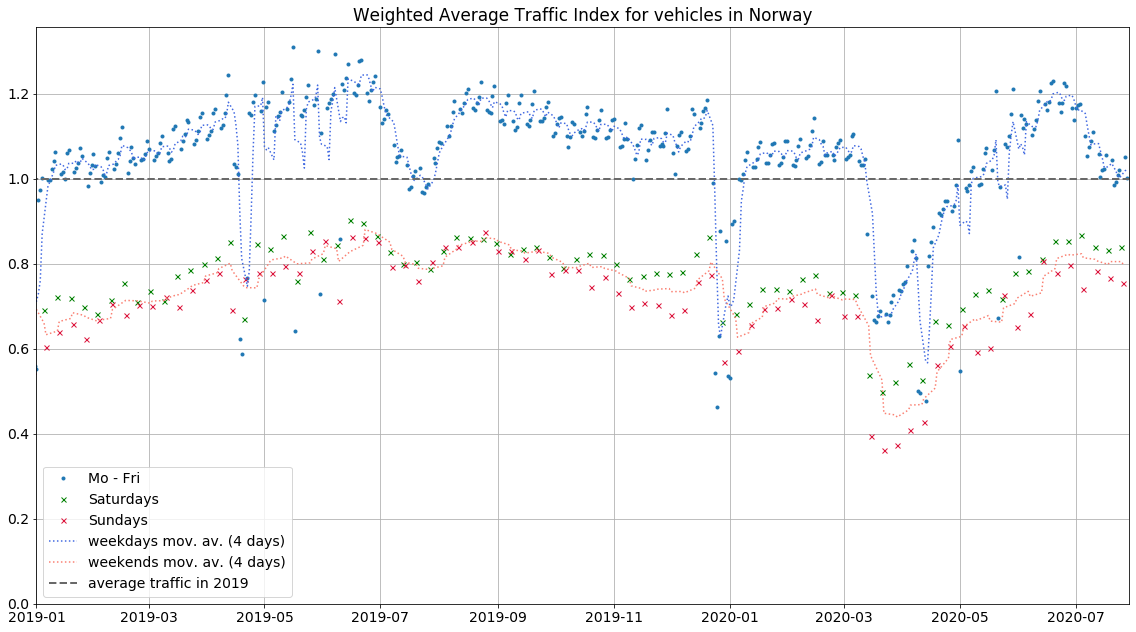

In [147]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE')].index
# read anew
fn = 'norway_vehicles.pkl'
# os.remove(fn) # uncomment this line to process the data anew
if not os.path.exists(fn):
    NV = process_TDD(ALL,IDs)
    NV_wavg = NV.groupby('date').apply(wavg,'traffic_index','YADTV')
    # saving:
    with open(fn, 'wb') as f:
        pickle.dump([NV, NV_wavg], f)
else:
    # loading:
    with open(fn,'rb') as f:
        NV, NV_wavg = pickle.load(f)
        
plot_TI(NV_wavg, title = 'Weighted Average Traffic Index for vehicles in Norway', save = True, MA = 4)

## Comparison of Oslo, Bergen, Stavanger and Norway

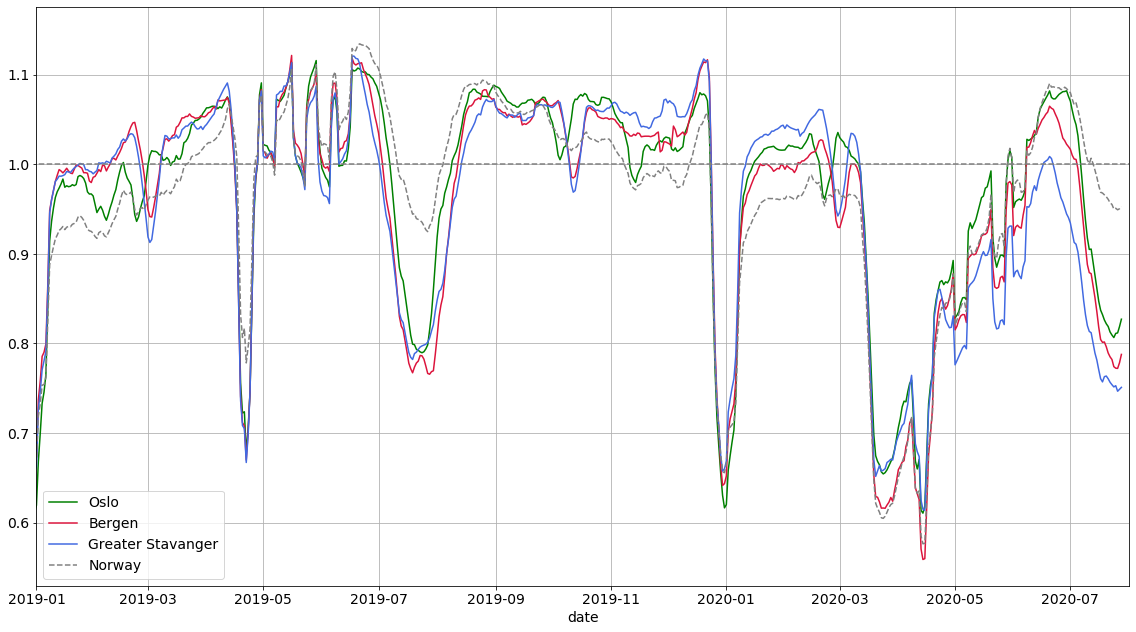

In [170]:
OSL_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Oslo', color = 'green', legend = True)
BRG_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Bergen', color = 'crimson', legend = True)
GSV_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Greater Stavanger', color = 'royalblue', legend = True)
NV_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Norway', color = 'grey', legend = True, ls = '--')
xl = plt.xlim()
plt.plot(xl, [1, 1],'--', color = 'gray')

from_date = datetime.fromisoformat('2019-01-01').date()
to_date = datetime.fromisoformat('2020-08-01').date()
    
plt.xlim(from_date,to_date)
plt.tight_layout()
plt.savefig('.\\figures\\Comparison of Oslo, Bergen, Stavanger and Norway.png',dpi=300)
plt.show()

### Bicycles

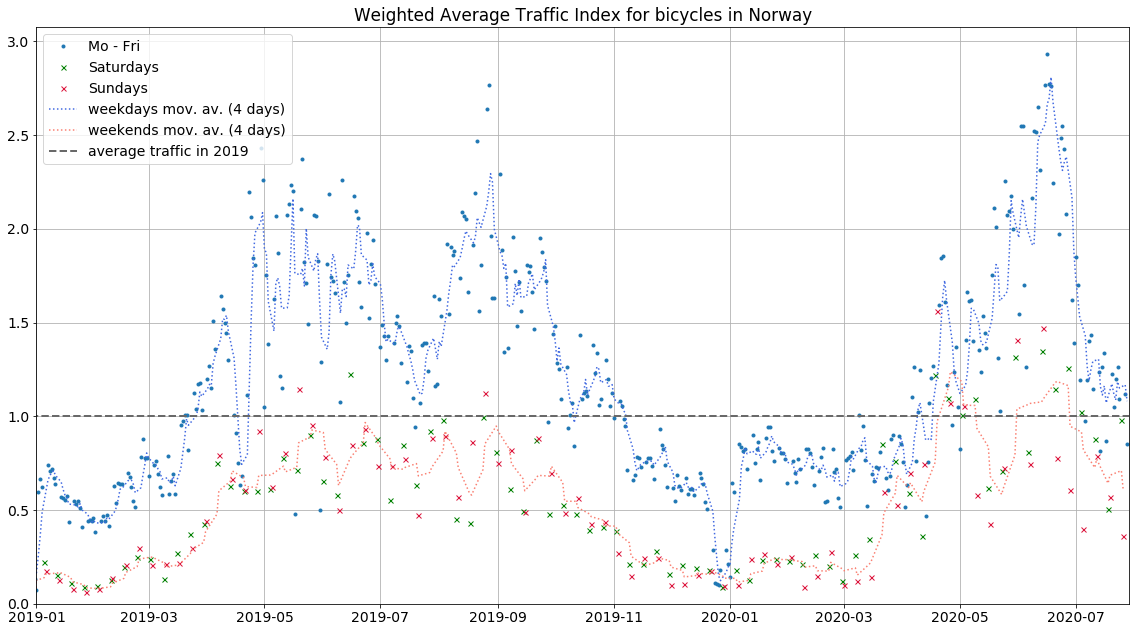

In [149]:
IDs = TRP.loc[(TRP.trafficType == 'BICYCLE')].index
# read anew
fn = 'norway_bicycles.pkl'
# os.remove(fn) # uncomment this line to process the data anew
if not os.path.exists(fn):
    NB = process_TDD(ALL,IDs)
    NB_wavg = NB.groupby('date').apply(wavg,'traffic_index','YADTV')
    # saving:
    with open(fn, 'wb') as f:
        pickle.dump([NB, NB_wavg], f)
else:
    # loading:
    with open(fn,'rb') as f:
        NB, NB_wavg = pickle.load(f)
        
plot_TI(NB_wavg, title = 'Weighted Average Traffic Index for bicycles in Norway', save = True, MA = 4)

## Airports

### Harstad/Narvik Airport (Evenes flyplass)

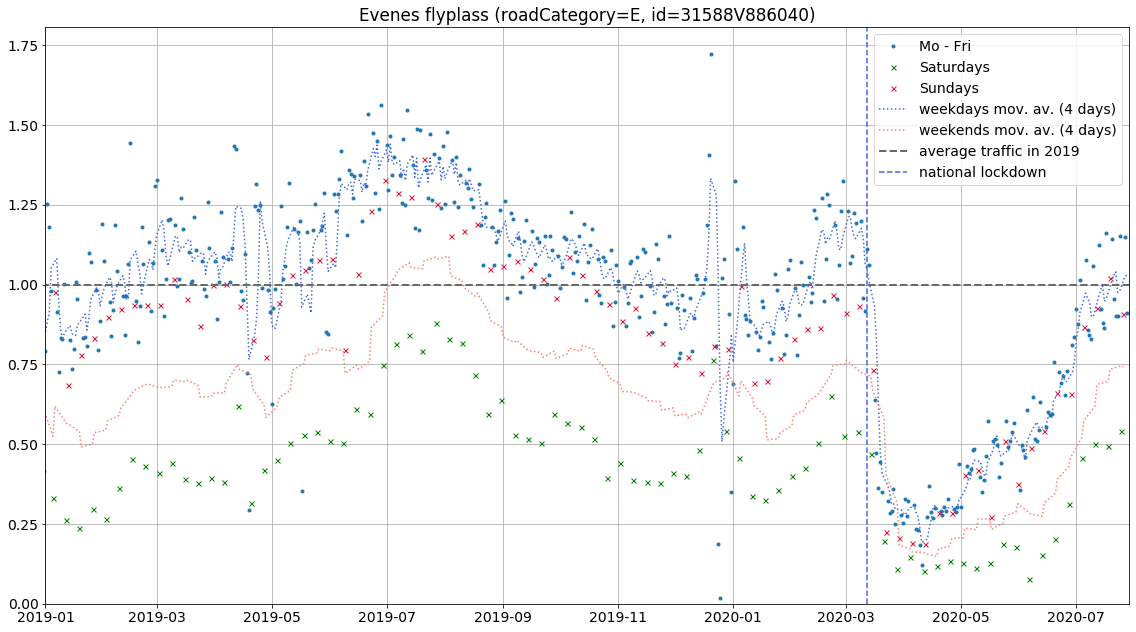

In [150]:
id = '31588V886040' # Evenes flyplass (Harstad/Narvik Airport)
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(ALL[id], id, from_date = '2019-01-01', to_date = time_now_str, marks = M, save = True, MA = 4)

### Bergen, Flesland

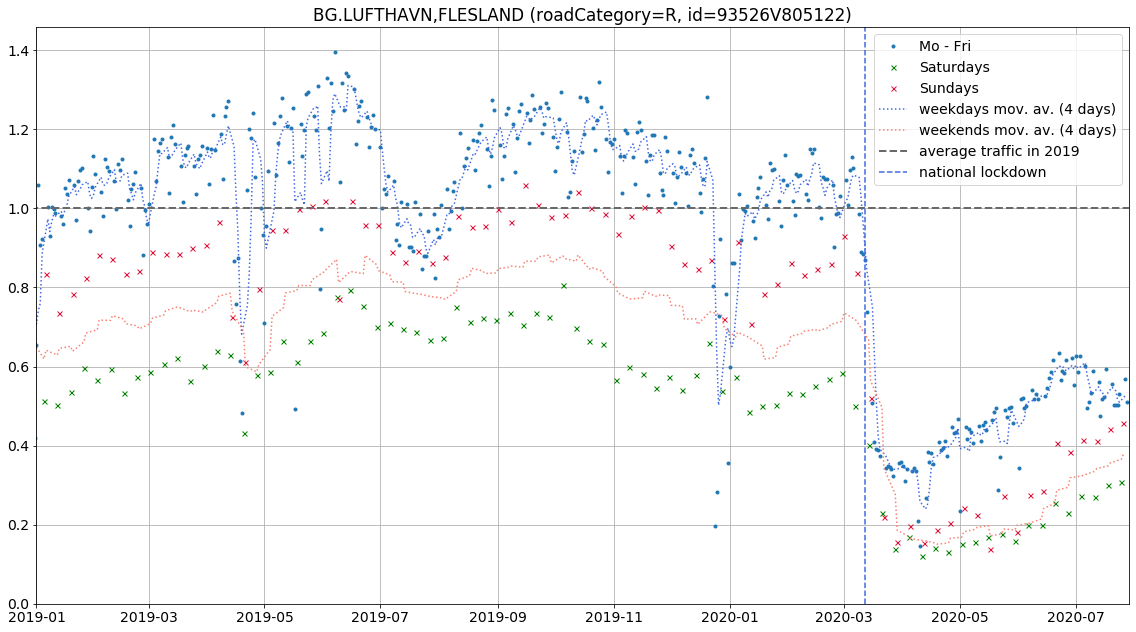

In [151]:
id = '93526V805122' # BG.LUFTHAVN,FLESLAND
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(ALL[id], id, from_date = '2019-01-01', to_date = time_now_str, marks = M, save = True, MA = 4)

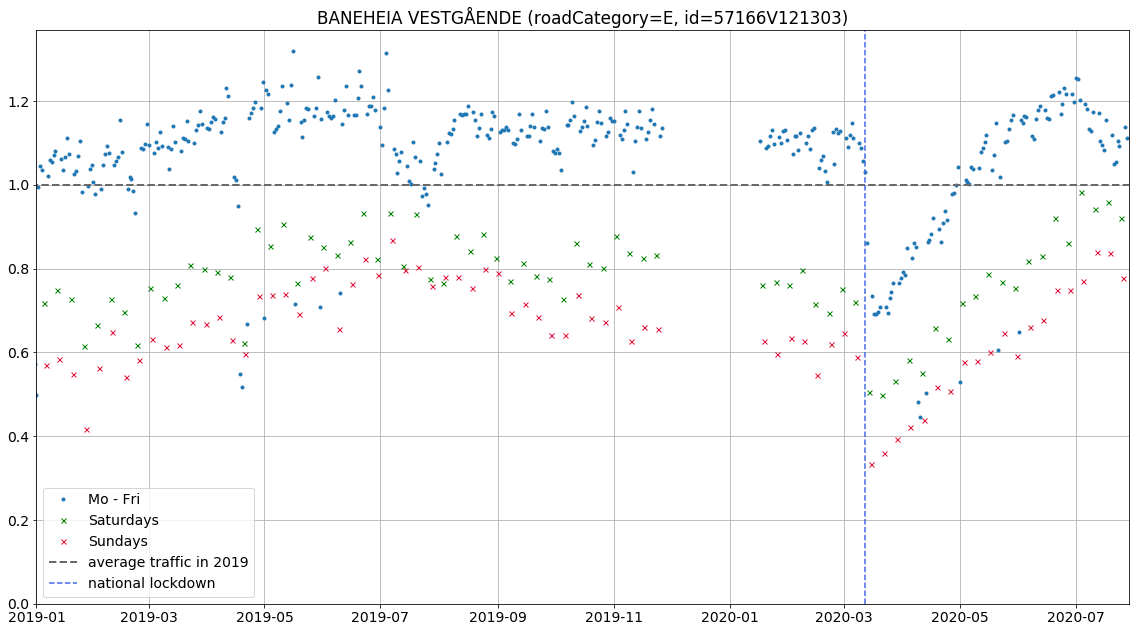

In [152]:
id = '57166V121303' # BANEHEIA VESTGÅENDE

M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}, 
    }

plot_TI(ALL[id], id, from_date = '2019-01-01', to_date = time_now_str, marks = M, save = True)

## Skiing areas

### Hol (Geilo)

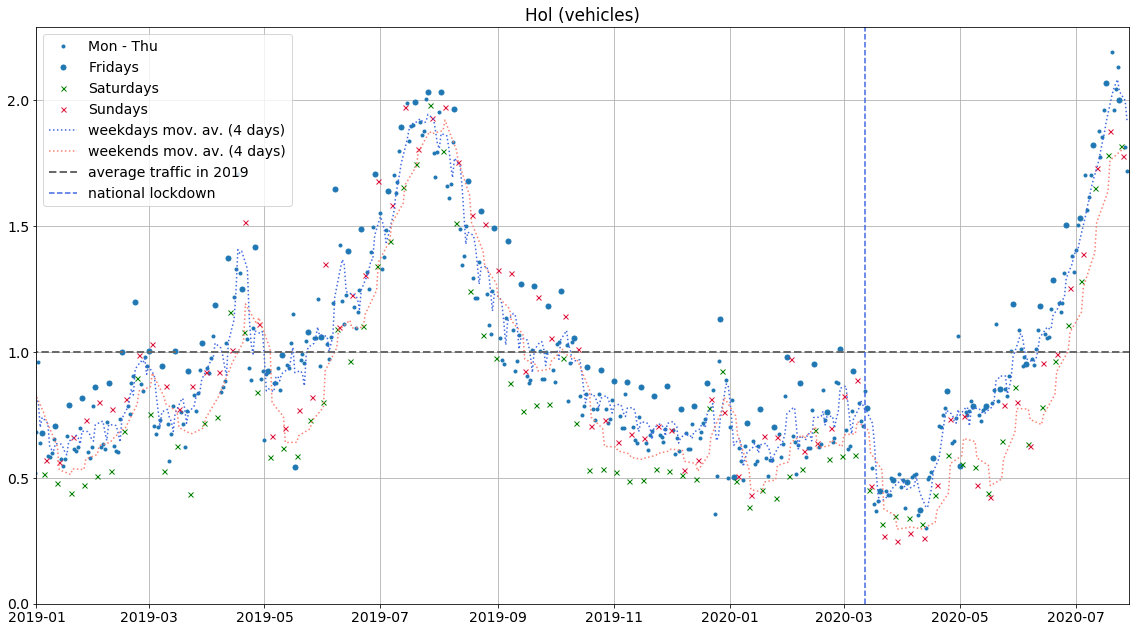

In [216]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Hol'])].index
Hol = process_TDD(ALL,IDs)
Hol_wavg = Hol.groupby('date').apply(wavg,'traffic_index','YADTV')
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(Hol_wavg, title = 'Hol (vehicles)', marks = M, save = True, MA = 4, fridays = True)

### Sirdal

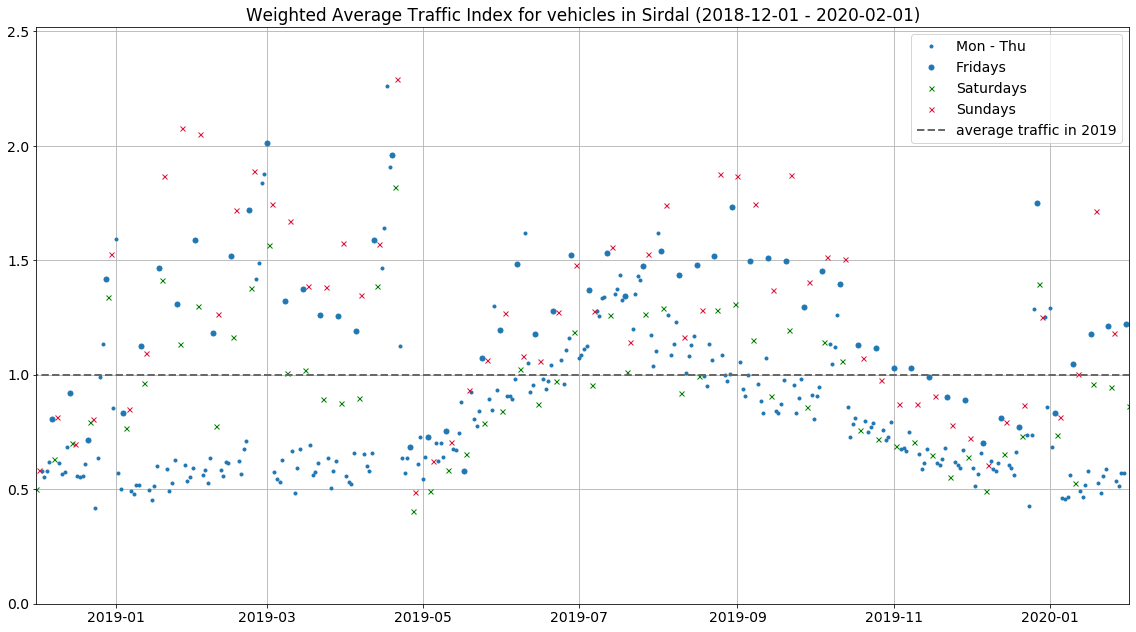

In [228]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Sirdal'])].index
Sirdal = process_TDD(ALL,IDs)
Sirdal_wavg = Sirdal.groupby('date').apply(wavg,'traffic_index','YADTV')
# plot_TI(Sirdal_wavg,marks = M, title = 'Weighted Average Traffic Index for vehicles in GSA 2018-12-01 - 2020-02-01', from_date = '2018-12-01', to_date = '2020-02-01', save = True, MA = 4)
plot_TI(Sirdal_wavg, title = 'Weighted Average Traffic Index for vehicles in Sirdal (2018-12-01 - 2020-02-01)', from_date = '2018-12-01', to_date = '2020-02-01', save = True, fridays = True)

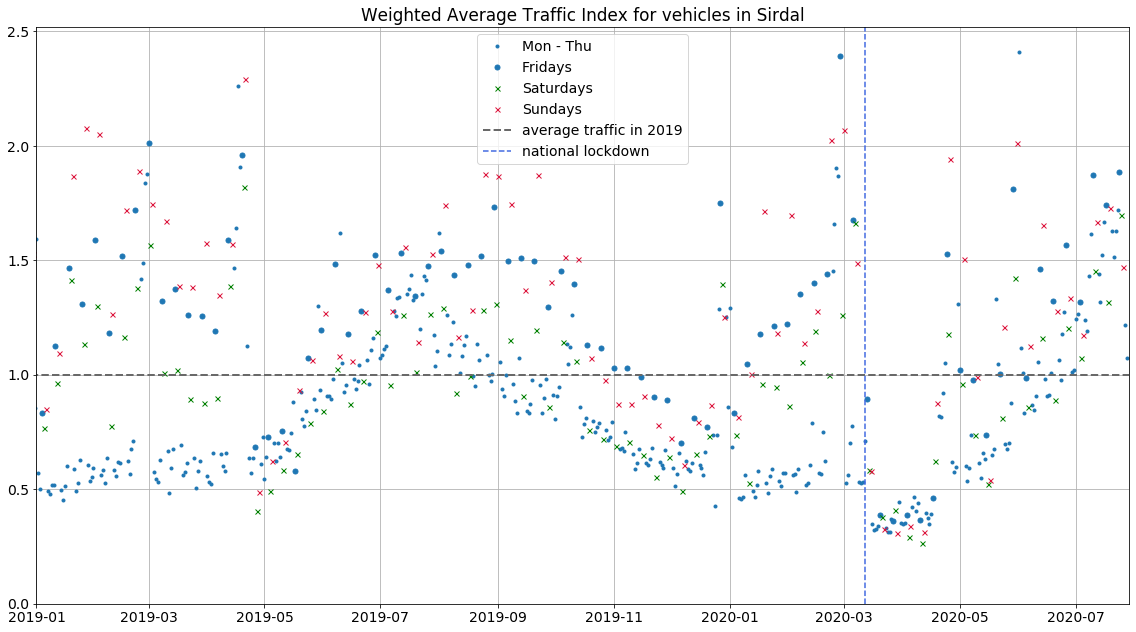

In [222]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Sirdal'])].index
Sirdal = process_TDD(ALL,IDs)
Sirdal_wavg = Sirdal.groupby('date').apply(wavg,'traffic_index','YADTV')
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}

# plot_TI(Sirdal_wavg,marks = M, title = 'Weighted Average Traffic Index for vehicles in GSA 2018-12-01 - 2020-02-01', from_date = '2018-12-01', to_date = '2020-02-01', save = True, MA = 4)
plot_TI(Sirdal_wavg, title = 'Weighted Average Traffic Index for vehicles in Sirdal', marks = M, save = True, fridays = True)

### Trysil

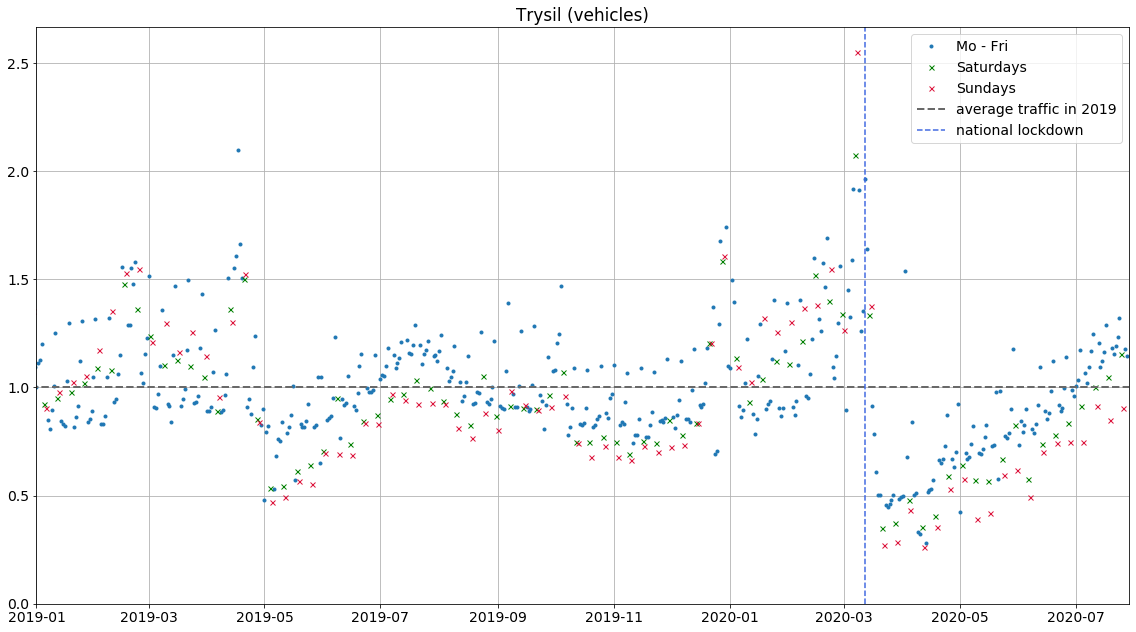

In [155]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Trysil'])].index
Trysil = process_TDD(ALL,IDs)
Trysil_wavg = Trysil.groupby('date').apply(wavg,'traffic_index','YADTV')
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(Trysil_wavg, title = 'Trysil (vehicles)', marks = M, save = True)

## Boarders

### Sweden (Svinesund bridge)

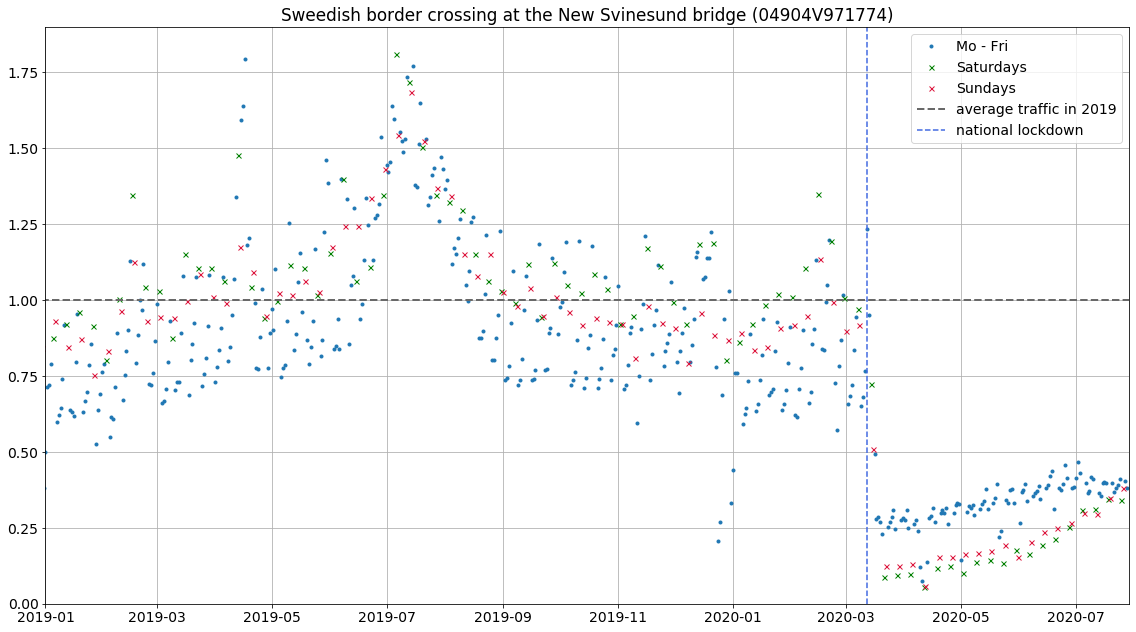

In [156]:
id = '04904V971774'  # NYE SVINESUND BRU, trafficType = VEHICLE, municipality = Halden
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(ALL[id], id, title = 'Sweedish border crossing at the New Svinesund bridge ('+id+')' , marks = M, save = True)

### Russia (Storskog)
Storskog is a border crossing station on the Norwegian side of the Norway-Russia border, along the European route E105 highway. The crossing is located in Sør-Varanger Municipality in Finnmark county on the Norway side of the border.
https://en.wikipedia.org/wiki/Storskog

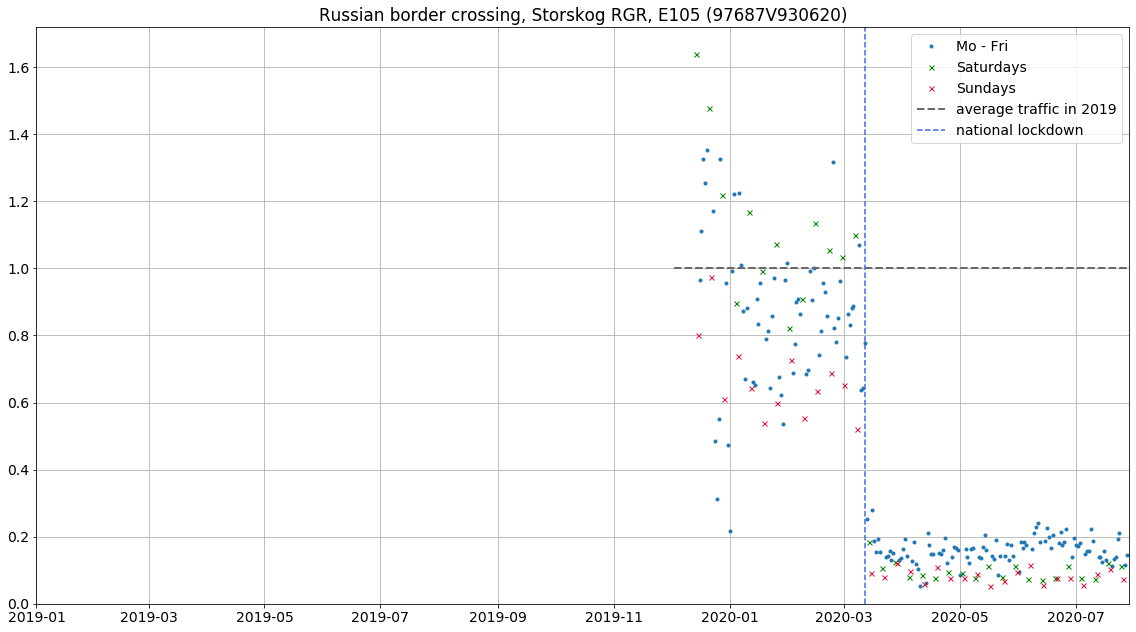

In [157]:
id = '97687V930620' # name = Storskog RGR, trafficType	VEHICLE, municipality = Sør-Varanger
# id = '61723V2435179'
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(ALL[id], id, title = 'Russian border crossing, ' + TRP.name[id] +', E105 ('+ id +')' , marks = M, save = True)

In [158]:
TRP.loc['97687V930620',:]

name                 Storskog RGR
trafficType               VEHICLE
municipality         Sør-Varanger
county          Troms og Finnmark
roadCategory                    E
road_ref         EV105 S2D1 m4494
lat                       69.6597
lon                       30.2033
Name: 97687V930620, dtype: object

### Finnland (Aidejavri RGR)

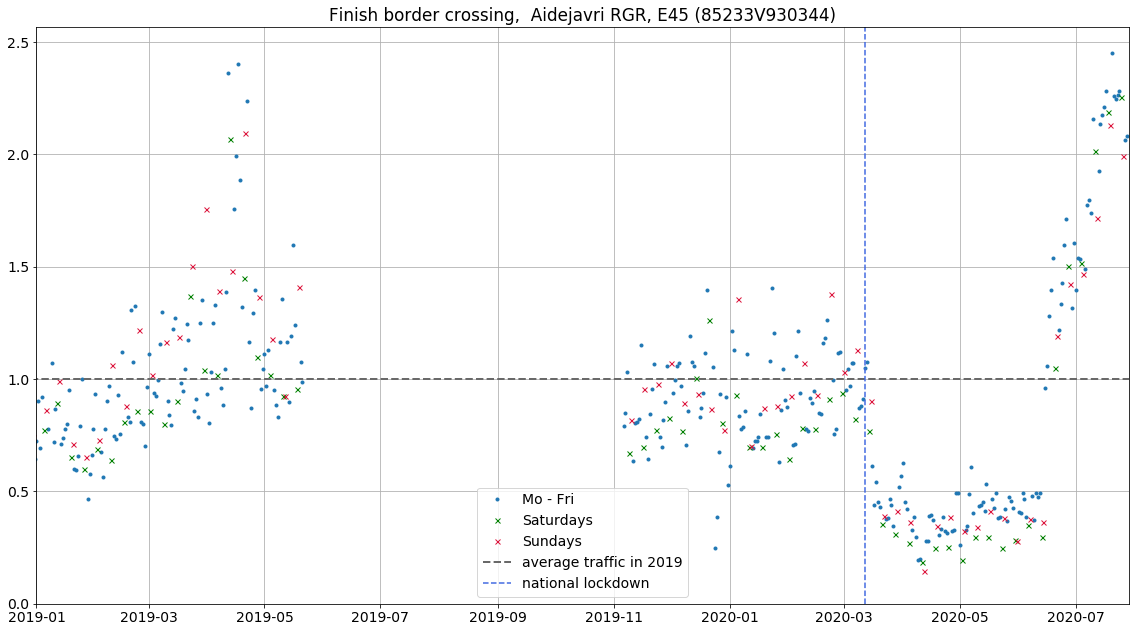

In [159]:
id = '85233V930344'  # Aidejavri RGR (E45), trafficType = VEHICLE, municipality	Kautokeino
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(ALL[id], id, title = 'Finish border crossing,  ' + TRP.name[id] +', E45 ('+ id +')' , marks = M, save = True)

## Preparing input for Kepler.GL to visualise year-over-year traffic ratio

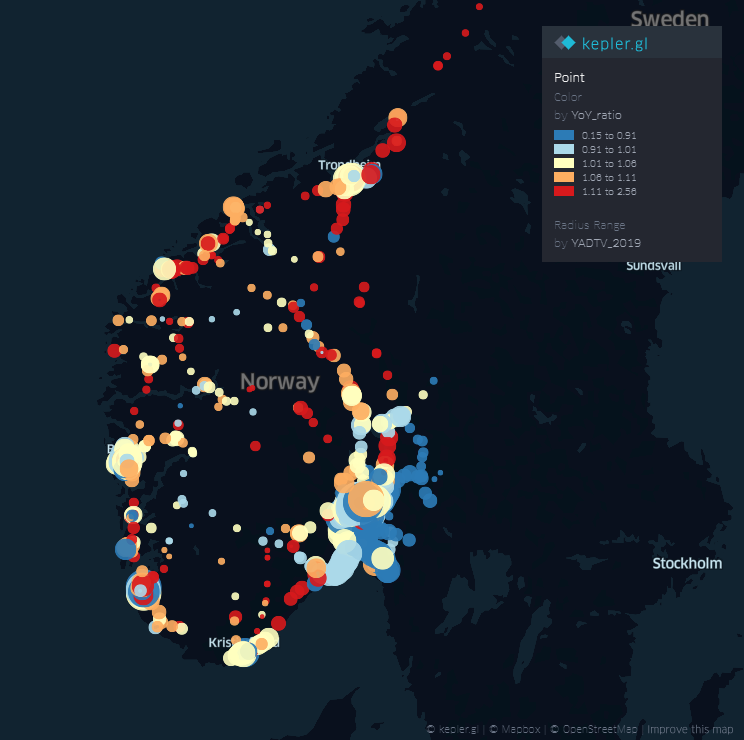

The code below:
- copies TRP to TRP_YoY
- adds the column YoY_ratio: [YoY_ratio] = [MA of Traffic Index @ t2]/[MA of Traffic Index @ t1]
- adds column with Yearly Averaged Daily Traffic Volume in 2019 YoY_ratio
- saves the result TRP_YoY.csv 

An example map is saved in 'YoY_traffic_comparison.json'

In [160]:
t1 = '2019-07-27' # 
t2 = '2020-07-27' #
tt1 = datetime.fromisoformat(t1).date()
tt2 = datetime.fromisoformat(t2).date()

TRP_YoY = TRP.copy()
for i,id in enumerate(ALL.keys()):
    try:
        TRP_YoY.loc[id,'YADTV_2019'] = ALL[id]['YADTV'][tt2]        
        YoY_ratio = ALL[id]['traffic_index_MA7'][tt2]/ALL[id]['traffic_index_MA7'][tt1]
        TRP_YoY.loc[id,'YoY_ratio'] = YoY_ratio
        l = 'ok'
    except:
        l = 'some error'
    print(i,id,l)        
    if (i + 1) % 25 == 0:
        clear_output()
        
TRP_YoY.replace([sp.inf, -sp.inf], sp.nan, inplace=True)
TRP_YoY.dropna(inplace=True)
TRP_YoY['YoY_ratio'] = TRP_YoY['YoY_ratio'].round(2)
# TRP_YoY.drop(columns = ['r'], inplace = True)
TRP_YoY = TRP_YoY.loc[(TRP_YoY['YoY_ratio']>0.01) & (TRP_YoY['YoY_ratio']<2.5),:]

TRP_YoY['YoY_bins'] = None

TRP_YoY['YoY_bins']  = pd.cut(TRP_YoY['YoY_ratio'], [-sp.inf, 0.75, 0.9, 1.1, 1.25, sp.inf],
                                   labels = ['1) <-25%', '2) -25%...+10%', '3) -10%...+10%', '4) +10%...+25%', '5) >+25%'])
TRP_YoY.to_csv('TRP_YoY.csv')
# TRP_YoY['YoY_ratio'].describe()
TRP_YoY

2475 94099V2038395 ok
2476 37343V1060687 ok
2477 28744V521077 some error
2478 73691V578198 some error
2479 77436V319718 ok
2480 01212V705242 ok
2481 48379V625405 ok
2482 29861V1832531 ok
2483 24742V1669523 ok
2484 89281V1206302 some error
2485 87740V971816 ok
2486 61394V604898 ok
2487 14910V1060192 ok
2488 20176V705149 ok


,name,trafficType,municipality,county,roadCategory,road_ref,lat,lon,YADTV_2019,YoY_ratio,YoY_bins
id,,,,,,,,,,,
02489V121427,VOLLEVATN,VEHICLE,Kristiansand,Agder,F,FV452 S1D1 m246,58.166603,8.033386,10489.0,1.07,3) -10%...+10%
56100V804816,RAMPE SØRÅS MOT HOP,VEHICLE,Bergen,Vestland,E,EV39 S78D1 m6434 KD3 m172,60.325803,5.337152,3466.0,0.98,3) -10%...+10%
03119V886010,STRAND N.,VEHICLE,Sortland,Nordland,F,FV82 S8D1 m302,68.709501,15.441047,2453.0,1.06,3) -10%...+10%
03486V319647,ØLEN/ETNE,VEHICLE,Vindafjord,Rogaland,E,EV134 S4D1 m17916,59.623114,5.886108,3976.0,1.15,4) +10%...+25%
00030V705190,MATRAND S,VEHICLE,Eidskog,Innlandet,R,RV2 S2D1 m4362,60.020618,12.113421,6472.0,0.57,1) <-25%
...,...,...,...,...,...,...,...,...,...,...,...
29861V1832531,LØRENSKOGVEIEN,VEHICLE,Lørenskog,Viken,R,RV163 S2D1 m909,59.940465,10.941508,19434.0,1.07,3) -10%...+10%
24742V1669523,TVEITEN,VEHICLE,Tønsberg,Vestfold og Telemark,E,EV18 S39D1 m2934,59.331926,10.378529,31336.0,1.07,3) -10%...+10%
87740V971816,HAFSLUND ØST,VEHICLE,Sarpsborg,Viken,R,RV22 S3D1 m4257,59.272765,11.143724,22134.0,1.12,4) +10%...+25%
